In [1]:
import pystan

import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

In [2]:
# reload packages from notebook whenever needed
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az # For visualization and loo
import seaborn as sns 

# Code by hand

In [4]:
data = {'N': 100, 'y': 50} #number of trials, number of successes

In [5]:
def p_data_given_theta(theta, data):
    return theta**data['y'] * (1-theta)**(data['N']-data['y'])

from scipy.stats import beta
def p_theta(theta):
    # beta(1, 1) prior
    return beta.pdf(theta, 1, 1)

def p_data(data, possible_theta_values=np.linspace(0, 1, 1000)):
    """
    This function is the marginal likelihood of the data.
    It is the integral of the likelihood function over possible values of theta, weighted by the prior.
    """
    unweighted_integral = np.sum([p_data_given_theta(theta, data) * p_theta(theta) for theta in possible_theta_values])
    integral = unweighted_integral / np.sum([p_theta(theta) for theta in possible_theta_values])
    return integral

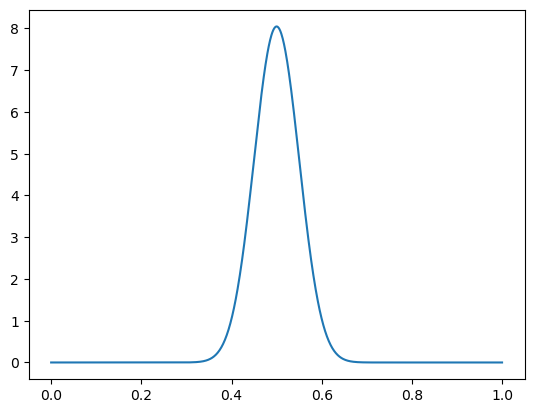

In [6]:
possible_theta_values = np.linspace(0, 1, 1000)

denominator = p_data(data, possible_theta_values)
p_theta_given_data = [p_data_given_theta(theta, data) * p_theta(theta) / denominator 
                      for theta in possible_theta_values]

plt.plot(possible_theta_values, p_theta_given_data)

# Using Stan to fit a binomial model

In [7]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'binom.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

// Binomial model with beta(1,1,) prior
data {
  int<lower=0> N;
  int<lower=0> y;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  y ~ binomial(N,theta);
}



In [8]:
stan_data = {'N': 100, 'y': 50} #number of trials, number of successes

In [9]:
model_code

'// Binomial model with beta(1,1,) prior\ndata {\n  int<lower=0> N;\n  int<lower=0> y;\n}\nparameters {\n  real<lower=0,upper=1> theta;\n}\nmodel {\n  theta ~ beta(1,1);\n  y ~ binomial(N,theta);\n}\n'

In [10]:
sm = pystan.StanModel(model_code=model_code, verbose = True, extra_compile_args= ["-flto"]) #flto = link time optimization I think for RAM issues?

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a05259dcade68de9675d2ad9b1145f54 NOW.
INFO:pystan:OS: linux, Python: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 15:55:03) 
[GCC 10.4.0], Cython 0.29.33


Compiling /tmp/pystan_ypsd1oot/stanfit4anon_model_a05259dcade68de9675d2ad9b1145f54_6433077372052408374.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_ypsd1oot/stanfit4anon_model_a05259dcade68de9675d2ad9b1145f54_6433077372052408374.pyx


INFO:root:building 'stanfit4anon_model_a05259dcade68de9675d2ad9b1145f54_6433077372052408374' extension
INFO:root:creating /tmp/pystan_ypsd1oot/tmp
INFO:root:creating /tmp/pystan_ypsd1oot/tmp/pystan_ypsd1oot
INFO:root:/home/nkgarg/miniconda3/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/nkgarg/miniconda3/envs/ractest2/include -fPIC -O2 -isystem /home/nkgarg/miniconda3/envs/ractest2/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/nkgarg/miniconda3/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/nkgarg/miniconda3/include -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_ypsd1oot -I/home/nkgarg/miniconda3/envs/ractest2/lib/python3.9/site-packages/pystan -I/home/nkgarg/miniconda3/envs/ractest2/lib/python3.9/site-packages/pystan/stan/src -I/home/nkgarg/miniconda3/envs/ractest2/lib/pytho

In [11]:
fit = sm.sampling(data=stan_data, chains=2, warmup  = 150, iter= 250, n_jobs = 1)



Gradient evaluation took 6e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
Iteration:  75 / 250 [ 30%]  (Warmup)
Iteration: 100 / 250 [ 40%]  (Warmup)
Iteration: 125 / 250 [ 50%]  (Warmup)
Iteration: 150 / 250 [ 60%]  (Warmup)
Iteration: 151 / 250 [ 60%]  (Sampling)
Iteration: 175 / 250 [ 70%]  (Sampling)
Iteration: 200 / 250 [ 80%]  (Sampling)
Iteration: 225 / 250 [ 90%]  (Sampling)
Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 0.000714 seconds (Warm-up)
               0.000367 seconds (Sampling)
               0.001081 seconds (Total)


Gradient evaluation took 2e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration

In [13]:
idata = az.from_pystan(posterior=fit, posterior_model=sm)

In [14]:
summary = az.summary(fit)

In [15]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.495,0.048,0.406,0.586,0.006,0.004,69.0,88.0,1.05


<AxesSubplot: title={'center': 'theta'}>

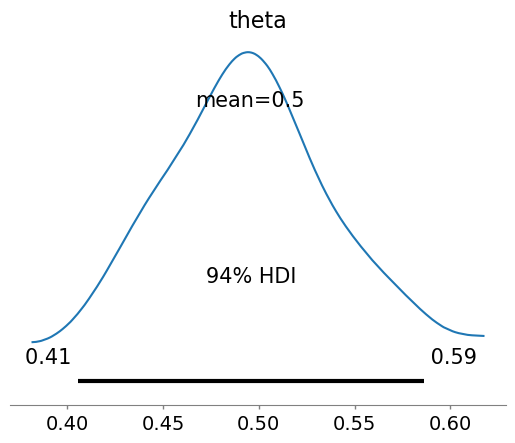

In [16]:
# Stan gives us _samples_ for theta, representing P(\theta | data)
az.plot_posterior(idata)

<AxesSubplot: xlabel='theta', ylabel='Count'>

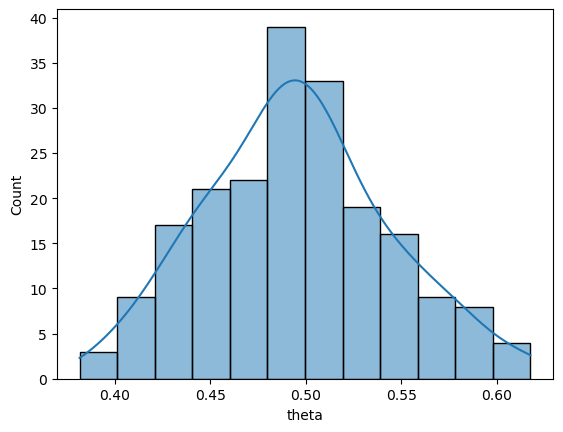

In [17]:
sns.histplot(data=az.extract(fit), x='theta', kde=True)

array([[<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

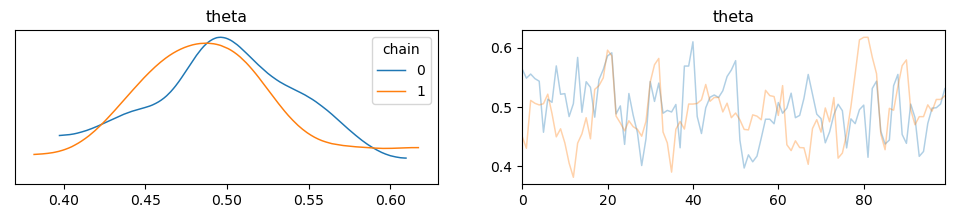

In [18]:
az.plot_trace(fit, compact=False, legend=True)